In [134]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from pyidw import idw

# Load Discrete Data and Continuous Data

In [4]:
dfDis = pd.read_csv(r"D:\Water Quailty\OEAT_Discrete-2022-Aug-31.csv")
dfDis.head()

C:\Users\xiang11\AppData\Local\Temp\ipykernel_26636\2477443654.py:1: DtypeWarning: Columns (6,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  dfDis = pd.read_csv(r"D:\Water Quailty\OEAT_Discrete-2022-Aug-31.csv")


,RowID,ProgramID,ProgramName,DataFileName,ParameterName,ParameterUnits,ProgramLocationID,ActivityType,SampleDate,Year,...,ResultComments,Latitude_DD,Longitude_DD,ManagedAreaName,Region,SEACAR_QAQCFlagCode,SEACAR_QAQC_Description,Include,SEACAR_EventID,AreaID
0,1,118,"National Aquatic Resource Surveys, National Co...",Data_118E_Final.csv,Chlorophyll a uncorrected for pheophytin,ug/L,FL01-0015,Sample,2001-12-31,2001,...,NaN,26.56520,-82.06790,Matlacha Pass Aquatic Preserve,SW,6Q,6Q - Within threshold tolerance,1,3521AFD2-7CB5-472C-9F0A-094711354B17,28
1,2,118,"National Aquatic Resource Surveys, National Co...",Data_118E_Final.csv,Chlorophyll a uncorrected for pheophytin,ug/L,FLW05-0009,Sample,2005-12-31,2005,...,NaN,26.58742,-82.06785,Matlacha Pass Aquatic Preserve,SW,6Q,6Q - Within threshold tolerance,1,4F7FAE89-44E6-4527-B780-62604BEDA08E,28
2,3,118,"National Aquatic Resource Surveys, National Co...",Data_118E_Final.csv,Chlorophyll a uncorrected for pheophytin,ug/L,FLW06-0042,Sample,2006-12-31,2006,...,NaN,26.63835,-82.21297,Pine Island Sound Aquatic Preserve,SW,6Q,6Q - Within threshold tolerance,1,135985C4-315B-430F-B56A-BCBA0ECEE7B8,34
3,4,118,"National Aquatic Resource Surveys, National Co...",Data_118E_Final.csv,Chlorophyll a uncorrected for pheophytin,ug/L,FLW06-0041,Sample,2006-12-31,2006,...,NaN,26.83697,-82.09640,Gasparilla Sound-Charlotte Harbor Aquatic Pres...,SW,6Q,6Q - Within threshold tolerance,1,ED7F7EC6-3254-4768-9CCC-7744025DFE2F,18
4,5,118,"National Aquatic Resource Surveys, National Co...",Data_118E_Final.csv,Chlorophyll a uncorrected for pheophytin,ug/L,FL00-0020,Sample,2000-12-31,2000,...,NaN,26.75800,-82.08850,Gasparilla Sound-Charlotte Harbor Aquatic Pres...,SW,6Q,6Q - Within threshold tolerance,1,B3933D86-BB5A-4431-AC1C-3793B782E615,18


In [5]:
dfCon = pd.read_csv(r"D:\Water Quailty\OEAT_Continuous-2022-Nov-04.csv")
dfCon.head()

C:\Users\xiang11\AppData\Local\Temp\ipykernel_26636\4096462767.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  dfCon = pd.read_csv(r"D:\Water Quailty\OEAT_Continuous-2022-Nov-04.csv")


,RowID,ProgramID,ProgramName,DataFileName,ParameterName,ParameterUnits,ProgramLocationID,ActivityType,SampleDate,Year,...,ResultComments,Latitude_DD,Longitude_DD,ManagedAreaName,Region,SEACAR_QAQCFlagCode,SEACAR_QAQC_Description,Include,SEACAR_EventID,AreaID
0,54292147,354,Rookery Bay National Estuarine Research Reserv...,Data_354B_Final.csv,Turbidity,NTU,gtmfmwq,NaN,2010-01-01,2010,...,NaN,29.737041,-81.245953,Guana Tolomato Matanzas National Estuarine Res...,NE,6Q,6Q - Within threshold tolerance,1,4B51AEFD-B82B-4A1B-9495-387380534325,20
1,54292148,354,Rookery Bay National Estuarine Research Reserv...,Data_354B_Final.csv,Dissolved Oxygen Saturation,%,gtmfmwq,NaN,2010-01-01,2010,...,NaN,29.737041,-81.245953,Guana Tolomato Matanzas National Estuarine Res...,NE,6Q,6Q - Within threshold tolerance,1,EA3E3E10-AC00-4E27-9792-B34F398DB47A,20
2,54292149,354,Rookery Bay National Estuarine Research Reserv...,Data_354B_Final.csv,Dissolved Oxygen Saturation,%,gtmfmwq,NaN,2010-01-01,2010,...,NaN,29.737041,-81.245953,Guana Tolomato Matanzas National Estuarine Res...,NE,6Q,6Q - Within threshold tolerance,1,7DFDEF12-6F63-46DE-B406-69846C4E3C5B,20
3,54292150,354,Rookery Bay National Estuarine Research Reserv...,Data_354B_Final.csv,Dissolved Oxygen Saturation,%,gtmfmwq,NaN,2010-01-01,2010,...,NaN,29.737041,-81.245953,Guana Tolomato Matanzas National Estuarine Res...,NE,6Q,6Q - Within threshold tolerance,1,ADA898FC-65D2-467D-B741-5EBA8C0A4C8C,20
4,54292151,354,Rookery Bay National Estuarine Research Reserv...,Data_354B_Final.csv,Water Temperature,Degrees C,gtmfmwq,NaN,2010-01-01,2010,...,NaN,29.737041,-81.245953,Guana Tolomato Matanzas National Estuarine Res...,NE,6Q,6Q - Within threshold tolerance,1,65C5A73E-30FF-49B6-B872-18585547CF95,20


In [8]:
def load_data(filepath):
    df = pd.read_csv(filepath)
    
    #---------- Select managed areas, and columns -----------------
    # df2 = df.loc[df["ManagedAreaName"].isin(["Guana Tolomato Matanzas National Estuarine Research Reserve",
    #                             "Biscayne Bay Aquatic Preserve",
    #                             "Estero Bay Aquatic Preserve",
    #                             "Gasparilla Sound-Charlotte Harbor Aquatic Preserve",
    #                             "Big Bend Seagrasses Aquatic Preserve"])]
    df2 = df
    df2 = df2[['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
               'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']]
    df2 = df2.loc[df2["ParameterName"].isin(["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"])]
    df2["timestamp"]=  pd.to_datetime(df2['SampleDate'])

    #---------- remove outliers -----------------
    # Remove total nitrogen outliers (>100)
    df2.drop(df2[(df2['ParameterName'] == 'Total Nitrogen') & 
        (df2['ResultValue'] > 10)].index,inplace=True)
    
    # Remove a single measurement in 1996-07-22 (RowID: 1582917)
    df2.drop(df2[df2['RowID'] == 1582917].index, inplace=True)
    
    # Remove turbidity outliers (>25)
    df2.drop(df2[(df2['ParameterName'] == 'Turbidity') & 
        (df2['ResultValue'] > 25)].index, inplace=True)
    
    # Remove Secchi Depth before 1995 (117 records)
    df2.drop(df2[(df2['ParameterName'] == 'Secchi Depth') & 
        (df2['Year'] < 1995)].index, inplace=True)
    
    #---------- create list of parameters, areas, values and dictionaries -----------------
    listPara = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 
    #listArea = ["Guana Tolomato Matanzas National Estuarine Research Reserve",
    #                             "Biscayne Bay Aquatic Preserve",
    #                             "Estero Bay Aquatic Preserve",
    #                             "Gasparilla Sound-Charlotte Harbor Aquatic Preserve",
    #                             "Big Bend Seagrasses Aquatic Preserve" ]
    listArea = df["ManagedAreaName"].unique()
    listValue = ["count", "mean","max","min","std"]
    dictUnits = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
    dictMonth = {1:"January",2:"February",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",
                 9:"September",10:"October",11:"November",12:"December"}
    dictArea = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass AP',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze AP','Pine Island Sound Aquatic Preserve':'Pine Island'}
    
    return df2, listPara, listArea, listValue, dictUnits, dictMonth, dictArea

In [9]:
dfDis = dfDis[['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
               'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']]
dfDis = dfDis.loc[dfDis["ParameterName"].isin(["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"])]
dfDis["timestamp"]=  pd.to_datetime(dfDis['SampleDate'])
#---------- remove outliers -----------------
# Remove total nitrogen outliers (>100)
dfDis.drop(dfDis[(dfDis['ParameterName'] == 'Total Nitrogen') & 
    (dfDis['ResultValue'] > 10)].index,inplace=True)

# Remove a single measurement in 1996-07-22 (RowID: 1582917)
dfDis.drop(dfDis[dfDis['RowID'] == 1582917].index, inplace=True)

# Remove turbidity outliers (>25)
dfDis.drop(dfDis[(dfDis['ParameterName'] == 'Turbidity') & 
    (dfDis['ResultValue'] > 25)].index, inplace=True)

# Remove Secchi Depth before 1995 (117 records)
dfDis.drop(dfDis[(dfDis['ParameterName'] == 'Secchi Depth') & 
    (dfDis['Year'] < 1995)].index, inplace=True)
dfDis.head()

,RowID,ParameterName,ParameterUnits,ProgramLocationID,ActivityType,ManagedAreaName,SampleDate,Year,Month,ResultValue,ValueQualifier,Latitude_DD,Longitude_DD,timestamp
19,20,Dissolved Oxygen,mg/L,FL01-0015,Field,Matlacha Pass Aquatic Preserve,2001-12-31,2001,12,6.0,NaN,26.56520,-82.06790,2001-12-31
20,21,Dissolved Oxygen,mg/L,FLW05-0009,Field,Matlacha Pass Aquatic Preserve,2005-12-31,2005,12,6.6,NaN,26.58742,-82.06785,2005-12-31
21,22,Dissolved Oxygen,mg/L,FLW06-0042,Field,Pine Island Sound Aquatic Preserve,2006-12-31,2006,12,5.1,NaN,26.63835,-82.21297,2006-12-31
22,23,Dissolved Oxygen,mg/L,FLW06-0041,Field,Gasparilla Sound-Charlotte Harbor Aquatic Pres...,2006-12-31,2006,12,5.5,NaN,26.83697,-82.09640,2006-12-31
23,24,Dissolved Oxygen,mg/L,FL00-0020,Field,Gasparilla Sound-Charlotte Harbor Aquatic Pres...,2000-12-31,2000,12,5.0,NaN,26.75800,-82.08850,2000-12-31


In [10]:
dfCon = dfCon[['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
               'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']]
dfCon = dfCon.loc[dfCon["ParameterName"].isin(["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"])]
dfCon["timestamp"]=  pd.to_datetime(dfCon['SampleDate'])
#---------- remove outliers -----------------
# Remove total nitrogen outliers (>100)
dfCon.drop(dfCon[(dfCon['ParameterName'] == 'Total Nitrogen') & 
    (dfDis['ResultValue'] > 10)].index,inplace=True)

# Remove a single measurement in 1996-07-22 (RowID: 1582917)
dfCon.drop(dfCon[dfCon['RowID'] == 1582917].index, inplace=True)

# Remove turbidity outliers (>25)
dfCon.drop(dfCon[(dfCon['ParameterName'] == 'Turbidity') & 
    (dfDis['ResultValue'] > 25)].index, inplace=True)

# Remove Secchi Depth before 1995 (117 records)
dfCon.drop(dfCon[(dfCon['ParameterName'] == 'Secchi Depth') & 
    (dfDis['Year'] < 1995)].index, inplace=True)
dfCon.head()

C:\Users\xiang11\AppData\Local\Temp\ipykernel_26636\3136528806.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfCon.drop(dfCon[(dfCon['ParameterName'] == 'Total Nitrogen') &
C:\Users\xiang11\AppData\Local\Temp\ipykernel_26636\3136528806.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfCon.drop(dfCon[(dfCon['ParameterName'] == 'Turbidity') &
C:\Users\xiang11\AppData\Local\Temp\ipykernel_26636\3136528806.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfCon.drop(dfCon[(dfCon['ParameterName'] == 'Secchi Depth') &


,RowID,ParameterName,ParameterUnits,ProgramLocationID,ActivityType,ManagedAreaName,SampleDate,Year,Month,ResultValue,ValueQualifier,Latitude_DD,Longitude_DD,timestamp
0,54292147,Turbidity,NTU,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2010-01-01,2010,1,2.0,0.0,29.737041,-81.245953,2010-01-01
7,54292154,Turbidity,NTU,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2010-01-01,2010,1,2.0,0.0,29.737041,-81.245953,2010-01-01
9,54292240,Dissolved Oxygen,mg/L,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2010-01-01,2010,1,8.2,0.0,29.737041,-81.245953,2010-01-01
12,54293339,Turbidity,NTU,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2010-01-01,2010,1,2.0,0.0,29.737041,-81.245953,2010-01-01
13,54293340,Dissolved Oxygen,mg/L,gtmfmwq,NaN,Guana Tolomato Matanzas National Estuarine Res...,2010-01-01,2010,1,7.8,0.0,29.737041,-81.245953,2010-01-01


In [11]:
dictArea    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass AP',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze AP','Pine Island Sound Aquatic Preserve':'Pine Island'}
dictUnits   = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
listArea    = dfCon["ManagedAreaName"].unique()
listPara    = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 
drySeason   = [5,6,7,8,9,10]
moistSeason = [11,12,1,2,3,4]

# Combine Dis Data and Con Data in Dry Season

In [12]:
dfConDry   = dfCon.loc[dfCon["Month"].isin(drySeason)]
dfConMoist = dfCon.loc[dfCon["Month"].isin(moistSeason)]

In [13]:
dfDisDry   = dfDis.loc[dfDis["Month"].isin(drySeason)]
dfDisMoist = dfDis.loc[dfDis["Month"].isin(moistSeason)]

In [14]:
dfDisDry.head(10)

,RowID,ParameterName,ParameterUnits,ProgramLocationID,ActivityType,ManagedAreaName,SampleDate,Year,Month,ResultValue,ValueQualifier,Latitude_DD,Longitude_DD,timestamp
77,78,Dissolved Oxygen,mg/L,GTMDNNUT,Field,Guana Tolomato Matanzas National Estuarine Res...,2017-07-20,2017,7,0.07,NaN,30.023197,-81.328333,2017-07-20
78,79,Dissolved Oxygen,mg/L,GTMDNNUT,Field,Guana Tolomato Matanzas National Estuarine Res...,2017-08-03,2017,8,4.73,NaN,30.023197,-81.328333,2017-08-03
79,80,Dissolved Oxygen,mg/L,GTMDSNUT,Field,Guana Tolomato Matanzas National Estuarine Res...,2017-08-03,2017,8,7.30,NaN,30.022867,-81.328056,2017-08-03
80,81,Dissolved Oxygen,mg/L,GTMDSNUT,Field,Guana Tolomato Matanzas National Estuarine Res...,2017-07-20,2017,7,0.09,NaN,30.022867,-81.328056,2017-07-20
81,82,Dissolved Oxygen,mg/L,GTMLSNUT,Field,Guana Tolomato Matanzas National Estuarine Res...,2017-10-18,2017,10,6.67,NaN,30.023763,-81.327928,2017-10-18
82,83,Dissolved Oxygen,mg/L,GTMLSNUT,Field,Guana Tolomato Matanzas National Estuarine Res...,2017-09-20,2017,9,5.36,NaN,30.023763,-81.327928,2017-09-20
84,85,Dissolved Oxygen,mg/L,GTMLSNUT,Field,Guana Tolomato Matanzas National Estuarine Res...,2018-06-11,2018,6,2.00,NaN,30.023763,-81.327928,2018-06-11
87,88,Dissolved Oxygen,mg/L,GTMLSNUT,Field,Guana Tolomato Matanzas National Estuarine Res...,2018-05-30,2018,5,4.25,NaN,30.023763,-81.327928,2018-05-30
93,94,Dissolved Oxygen,mg/L,GTMMKNUT,Field,Guana Tolomato Matanzas National Estuarine Res...,2017-07-20,2017,7,1.62,NaN,30.160736,-81.360278,2017-07-20
94,95,Dissolved Oxygen,mg/L,GTMMKNUT,Field,Guana Tolomato Matanzas National Estuarine Res...,2017-10-18,2017,10,5.16,NaN,30.160736,-81.360278,2017-10-18


In [15]:
dfDisDryMean = dfDisDry[dfDisDry["ParameterName"]==listPara[0]]
dfDisDryMean = dfDisDryMean.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()
dfDisDryMean

,Latitude_DD,Longitude_DD,ParameterName,ManagedAreaName,ResultValue
0,25.290600,-80.369800,Salinity,Biscayne Bay Aquatic Preserve,21.250000
1,25.300400,-80.331000,Salinity,Biscayne Bay Aquatic Preserve,25.750000
2,25.300950,-80.308550,Salinity,Biscayne Bay Aquatic Preserve,38.050000
3,25.301890,-80.306170,Salinity,Biscayne Bay Aquatic Preserve,36.970000
4,25.304460,-80.305370,Salinity,Biscayne Bay Aquatic Preserve,31.300000
...,...,...,...,...,...
24990,30.301390,-83.980280,Salinity,Big Bend Seagrasses Aquatic Preserve,0.105000
24991,30.338761,-83.985058,Salinity,Big Bend Seagrasses Aquatic Preserve,0.150000
24992,30.338761,-83.985058,Salinity,Big Bend Seagrasses Aquatic Preserve,0.166667
24993,30.369722,-83.806944,Salinity,Big Bend Seagrasses Aquatic Preserve,0.066591


In [16]:
dfConDryMean = dfConDry[dfConDry["ParameterName"]==listPara[0]]
dfConDryMean = dfConDryMean.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("mean").reset_index()
dfConDryMean

,Latitude_DD,Longitude_DD,ParameterName,ManagedAreaName,ResultValue
0,25.758020,-80.167690,Salinity,Biscayne Bay Aquatic Preserve,33.970643
1,25.769800,-80.180850,Salinity,Biscayne Bay Aquatic Preserve,33.400154
2,25.777300,-80.204000,Salinity,Biscayne Bay Aquatic Preserve,12.148200
3,25.821730,-80.151250,Salinity,Biscayne Bay Aquatic Preserve,30.533590
4,25.830030,-80.158600,Salinity,Biscayne Bay Aquatic Preserve,29.515927
5,25.846841,-80.182861,Salinity,Biscayne Bay Aquatic Preserve,13.299730
6,26.355000,-81.844500,Salinity,Estero Bay Aquatic Preserve,27.817076
7,26.385900,-81.846300,Salinity,Estero Bay Aquatic Preserve,32.740939
8,26.434900,-81.911400,Salinity,Estero Bay Aquatic Preserve,28.471148
9,26.449685,-81.871465,Salinity,Estero Bay Aquatic Preserve,23.089204


In [17]:
dfDryMean = pd.concat([dfConDryMean,dfDisDryMean],ignore_index=True)
dfDryMean

,Latitude_DD,Longitude_DD,ParameterName,ManagedAreaName,ResultValue
0,25.758020,-80.167690,Salinity,Biscayne Bay Aquatic Preserve,33.970643
1,25.769800,-80.180850,Salinity,Biscayne Bay Aquatic Preserve,33.400154
2,25.777300,-80.204000,Salinity,Biscayne Bay Aquatic Preserve,12.148200
3,25.821730,-80.151250,Salinity,Biscayne Bay Aquatic Preserve,30.533590
4,25.830030,-80.158600,Salinity,Biscayne Bay Aquatic Preserve,29.515927
...,...,...,...,...,...
25012,30.301390,-83.980280,Salinity,Big Bend Seagrasses Aquatic Preserve,0.105000
25013,30.338761,-83.985058,Salinity,Big Bend Seagrasses Aquatic Preserve,0.150000
25014,30.338761,-83.985058,Salinity,Big Bend Seagrasses Aquatic Preserve,0.166667
25015,30.369722,-83.806944,Salinity,Big Bend Seagrasses Aquatic Preserve,0.066591


In [18]:
gdfDry = gpd.GeoDataFrame(dfDryMean, geometry = gpd.points_from_xy(dfDryMean.Longitude_DD, dfDryMean.Latitude_DD), crs="EPSG:4326")
gdfDry

,Latitude_DD,Longitude_DD,ParameterName,ManagedAreaName,ResultValue,geometry
0,25.758020,-80.167690,Salinity,Biscayne Bay Aquatic Preserve,33.970643,POINT (-80.16769 25.75802)
1,25.769800,-80.180850,Salinity,Biscayne Bay Aquatic Preserve,33.400154,POINT (-80.18085 25.76980)
2,25.777300,-80.204000,Salinity,Biscayne Bay Aquatic Preserve,12.148200,POINT (-80.20400 25.77730)
3,25.821730,-80.151250,Salinity,Biscayne Bay Aquatic Preserve,30.533590,POINT (-80.15125 25.82173)
4,25.830030,-80.158600,Salinity,Biscayne Bay Aquatic Preserve,29.515927,POINT (-80.15860 25.83003)
...,...,...,...,...,...,...
25012,30.301390,-83.980280,Salinity,Big Bend Seagrasses Aquatic Preserve,0.105000,POINT (-83.98028 30.30139)
25013,30.338761,-83.985058,Salinity,Big Bend Seagrasses Aquatic Preserve,0.150000,POINT (-83.98506 30.33876)
25014,30.338761,-83.985058,Salinity,Big Bend Seagrasses Aquatic Preserve,0.166667,POINT (-83.98506 30.33876)
25015,30.369722,-83.806944,Salinity,Big Bend Seagrasses Aquatic Preserve,0.066591,POINT (-83.80694 30.36972)


In [20]:
gdfTest = gdfDry[(gdfDry.ParameterName == listPara[0]) & (gdfDry.ManagedAreaName == listArea[1])].reset_index(drop=True)
gdfTest.head()

,Latitude_DD,Longitude_DD,ParameterName,ManagedAreaName,ResultValue,geometry
0,26.562700,-82.070400,Salinity,Matlacha Pass Aquatic Preserve,21.366850,POINT (-82.07040 26.56270)
1,26.628800,-82.067400,Salinity,Matlacha Pass Aquatic Preserve,19.999157,POINT (-82.06740 26.62880)
2,26.667800,-82.094600,Salinity,Matlacha Pass Aquatic Preserve,23.975257,POINT (-82.09460 26.66780)
3,26.531917,-82.039667,Salinity,Matlacha Pass Aquatic Preserve,20.900000,POINT (-82.03967 26.53192)
4,26.541967,-82.046967,Salinity,Matlacha Pass Aquatic Preserve,10.200000,POINT (-82.04697 26.54197)


In [21]:
gdfTest.to_file('gdfTest.shp', driver='ESRI Shapefile',crs="EPSG:4326")

C:\Users\xiang11\AppData\Local\Temp\ipykernel_26636\4139369764.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfTest.to_file('gdfTest.shp', driver='ESRI Shapefile',crs="EPSG:4326")


In [71]:
gdfTestShp = gpd.read_file(r"TestIDW\Myself\gdfTest.shp")
# extentShp  = gpd.read_file(r"D:\Water Quailty\ManagedArea\ORCP_Managed_Areas_Oct2021.shp")
extentShp  = gpd.read_file(r"ManagedArea\ORCP_Managed_Areas_Oct2021.shp")

In [31]:
gdfTestShp

,Latitude_D,Longitude_,ParameterN,ManagedAre,ResultValu,geometry
0,26.562700,-82.070400,Salinity,Matlacha Pass Aquatic Preserve,21.366850,POINT (-82.07040 26.56270)
1,26.628800,-82.067400,Salinity,Matlacha Pass Aquatic Preserve,19.999157,POINT (-82.06740 26.62880)
2,26.667800,-82.094600,Salinity,Matlacha Pass Aquatic Preserve,23.975257,POINT (-82.09460 26.66780)
3,26.531917,-82.039667,Salinity,Matlacha Pass Aquatic Preserve,20.900000,POINT (-82.03967 26.53192)
4,26.541967,-82.046967,Salinity,Matlacha Pass Aquatic Preserve,10.200000,POINT (-82.04697 26.54197)
...,...,...,...,...,...,...
1175,26.724366,-82.075883,Salinity,Matlacha Pass Aquatic Preserve,36.500000,POINT (-82.07588 26.72437)
1176,26.724417,-82.075800,Salinity,Matlacha Pass Aquatic Preserve,22.500000,POINT (-82.07580 26.72442)
1177,26.724950,-82.075883,Salinity,Matlacha Pass Aquatic Preserve,21.300000,POINT (-82.07588 26.72495)
1178,26.725133,-82.075233,Salinity,Matlacha Pass Aquatic Preserve,20.350000,POINT (-82.07523 26.72513)


In [72]:
extentShp = extentShp[extentShp["LONG_NAME"] == listArea[1]]
extentShp

,LONG_NAME,Acres,Mgmt_Unit,AreaID,MA_AreaID,MA_Name,MA_Region,ACRES_2019,DateOfDesi,DEP_Webpag,Shape_Leng,Shape_Area,geometry
5,Matlacha Pass Aquatic Preserve,14621.903898,Aquatic Preserve,28,28,Matlacha Pass,SW,14621.903909,1972,https://floridadep.gov/rcp/aquatic-preserve/lo...,194735.826311,5.917275e+07,"MULTIPOLYGON (((-82.07480 26.72544, -82.07473 ..."


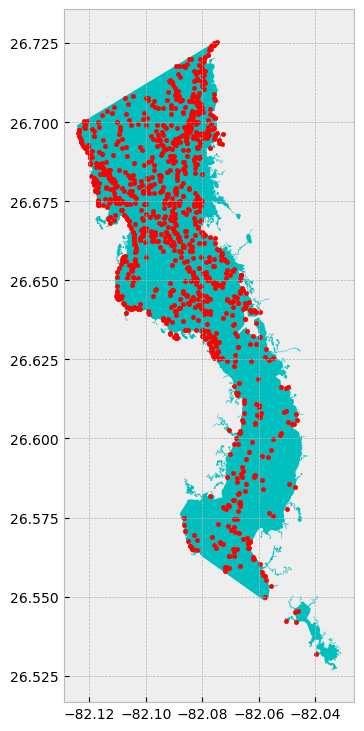

In [73]:
fig,ax = plt.subplots(figsize=(10,9))
extentShp.plot(ax=ax, color='c')
gdfTestShp.plot(ax=ax, marker='.', color='r')
plt.show()

# Preprocess for Interpolation

In [74]:
# Get X and Y coordinates
x_point = gdfTestShp["Longitude_"]
y_point = gdfTestShp["Latitude_D"]

# Create list of XY coordinate pairs
coords_point = [list(xy) for xy in zip(x_point, y_point)]

# Get extent of basins feature
min_x_basins, min_y_basins, max_x_basins, max_y_basins = extentShp.total_bounds

# Get list of "values"
value_point = list(gdfTestShp["ResultValu"])

# Create a copy of basins dataset
basins_dissolved = extentShp.copy()

# Add a field with constant value of 1
basins_dissolved["constant"] = 1

# Dissolve all counties to create one polygon
basins_dissolved = basins_dissolved.dissolve(by = "constant").reset_index(drop = True)

proj = gdfTestShp.crs

In [75]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z.shape[0],
            width = Z.shape[1],
            count = 1,
            dtype = Z.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z, 1)

In [76]:
# Split data into testing and training sets
coords_point_train, coords_point_test, value_point_train, value_point_test = train_test_split(coords_point, value_point, test_size = 0.20, random_state = 42)

# Create separate GeoDataFrames for testing and training sets
point_train_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_point_train], crs = proj)
point_train_gdf["Actual_Value"] = value_point_train
point_test_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_point_test], crs = proj)
point_test_gdf["Actual_Value"] = value_point_test

# Get minimum and maximum coordinate values of rainfall training points
min_x_point, min_y_point, max_x_point, max_y_point = point_train_gdf.total_bounds

<AxesSubplot: >

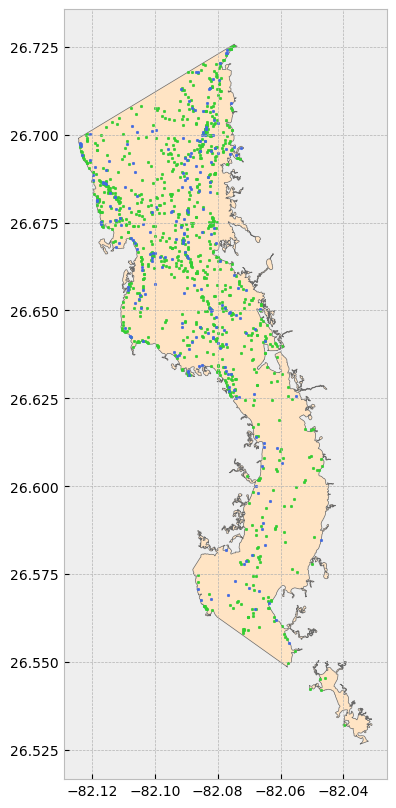

In [77]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Stylize plots
plt.style.use('bmh')

# Plot data
extentShp.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')
point_train_gdf.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 3)
point_test_gdf.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 3)
# Set title
# ax.set_title('Test Locations', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# Thiessen

In [79]:
# Extend extent of counties feature by using buffer
basins_buffer = extentShp.buffer(100000)

# Get extent of buffered input feature
min_x_cty_tp, min_y_cty_tp, max_x_cty_tp, max_y_cty_tp = basins_buffer.total_bounds

# Use extent to create dummy points and add them to list of coordinates
coords_tp = coords_point_train + [[min_x_cty_tp, min_y_cty_tp], [max_x_cty_tp, min_y_cty_tp],
                                 [max_x_cty_tp, max_y_cty_tp], [min_x_cty_tp, max_y_cty_tp]]

# Compute Voronoi diagram
tp = Voronoi(coords_tp)

# Create empty list of hold Voronoi polygons
tp_poly_list = []

# Create a polygon for each region
# 'regions' attribute provides a list of indices of the vertices (in the 'vertices' attribute) that make up the region
# Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html
for region in tp.regions:

    # Ignore region if -1 is in the list (based on documentation)
    if -1 in region:

        # Return to top of loop
        continue

    # Otherwise, pass
    else:
        pass

    # Check that region list has values in it
    if len(region) != 0:

        # Create a polygon by using the region list to call the correct elements in the 'vertices' attribute
        tp_poly_region = Polygon(list(tp.vertices[region]))

        # Append polygon to list
        tp_poly_list.append(tp_poly_region)

    # If no values, return to top of loop
    else:
        continue

# Create GeoDataFrame from list of polygon regions
tp_polys = gpd.GeoDataFrame(tp_poly_list, columns = ['geometry'], crs = proj)

# Clip polygon regions to the basins boundary
tp_polys_clipped = gpd.clip(tp_polys, basins_dissolved)

C:\Users\xiang11\AppData\Local\Temp\ipykernel_26636\1243620083.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  basins_buffer = extentShp.buffer(100000)


In [80]:
# If rainfall point within the polygon, assign that rainfall value to the polygon
tp_polys_clipped_values = gpd.sjoin(point_train_gdf, tp_polys_clipped, how = "right", op = 'within')

# Drop un-needed column
tp_polys_clipped_values = tp_polys_clipped_values.drop("index_left", axis = 1)

# Rename column
tp_polys_clipped_values = tp_polys_clipped_values.rename(columns = {"Actual_Value": "VALUE_Thiessen"})

# Display head of attribute table
print("Attribute Table: Thiessen Polygon Interpolated Values")
display(tp_polys_clipped_values.head())

Attribute Table: Thiessen Polygon Interpolated Values


C:\Users\xiang11\.conda\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,VALUE_Thiessen,geometry
23,27.4,"POLYGON ((-82.11296 26.69524, -82.12173 26.691..."
23,15.1,"POLYGON ((-82.11296 26.69524, -82.12173 26.691..."
23,32.4,"POLYGON ((-82.11296 26.69524, -82.12173 26.691..."
23,39.8,"POLYGON ((-82.11296 26.69524, -82.12173 26.691..."
23,12.8,"POLYGON ((-82.11296 26.69524, -82.12173 26.691..."


In [82]:
# If test point is within a polygon, assign that polygon's value to the test point
point_test_pred_tp = gpd.sjoin(point_test_gdf, tp_polys_clipped_values, how = "left", op = 'within')

# Drop un-needed column
point_test_pred_tp = point_test_pred_tp.drop("index_right", axis = 1)

# Rename column
point_test_pred_tp = point_test_pred_tp.rename(columns = {"Actual_Value": "VALUE_Actual", "VALUE_Thiessen": "VALUE_Predict"})

# Generate out-of-sample R^2
out_r_squared_tp = r2_score(point_test_pred_tp.VALUE_Actual, point_test_pred_tp.VALUE_Predict)
print("Thiessen polygon out-of-sample r-squared: {}".format(round(out_r_squared_tp, 2)))

# Display attribute table
print("\nAttribute Table: Testing Dataset Interpolated Values - Thiessen Polygon Method")
display(point_test_pred_tp.head(2))

C:\Users\xiang11\.conda\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Thiessen polygon out-of-sample r-squared: -1.04

Attribute Table: Testing Dataset Interpolated Values - Thiessen Polygon Method


,geometry,VALUE_Actual,VALUE_Predict
0,POINT (-82.07728 26.63285),25.4,21.90
0,POINT (-82.07728 26.63285),25.4,33.55


Text(0.5, 1.0, 'Test Locations & Thiessen Polygons')

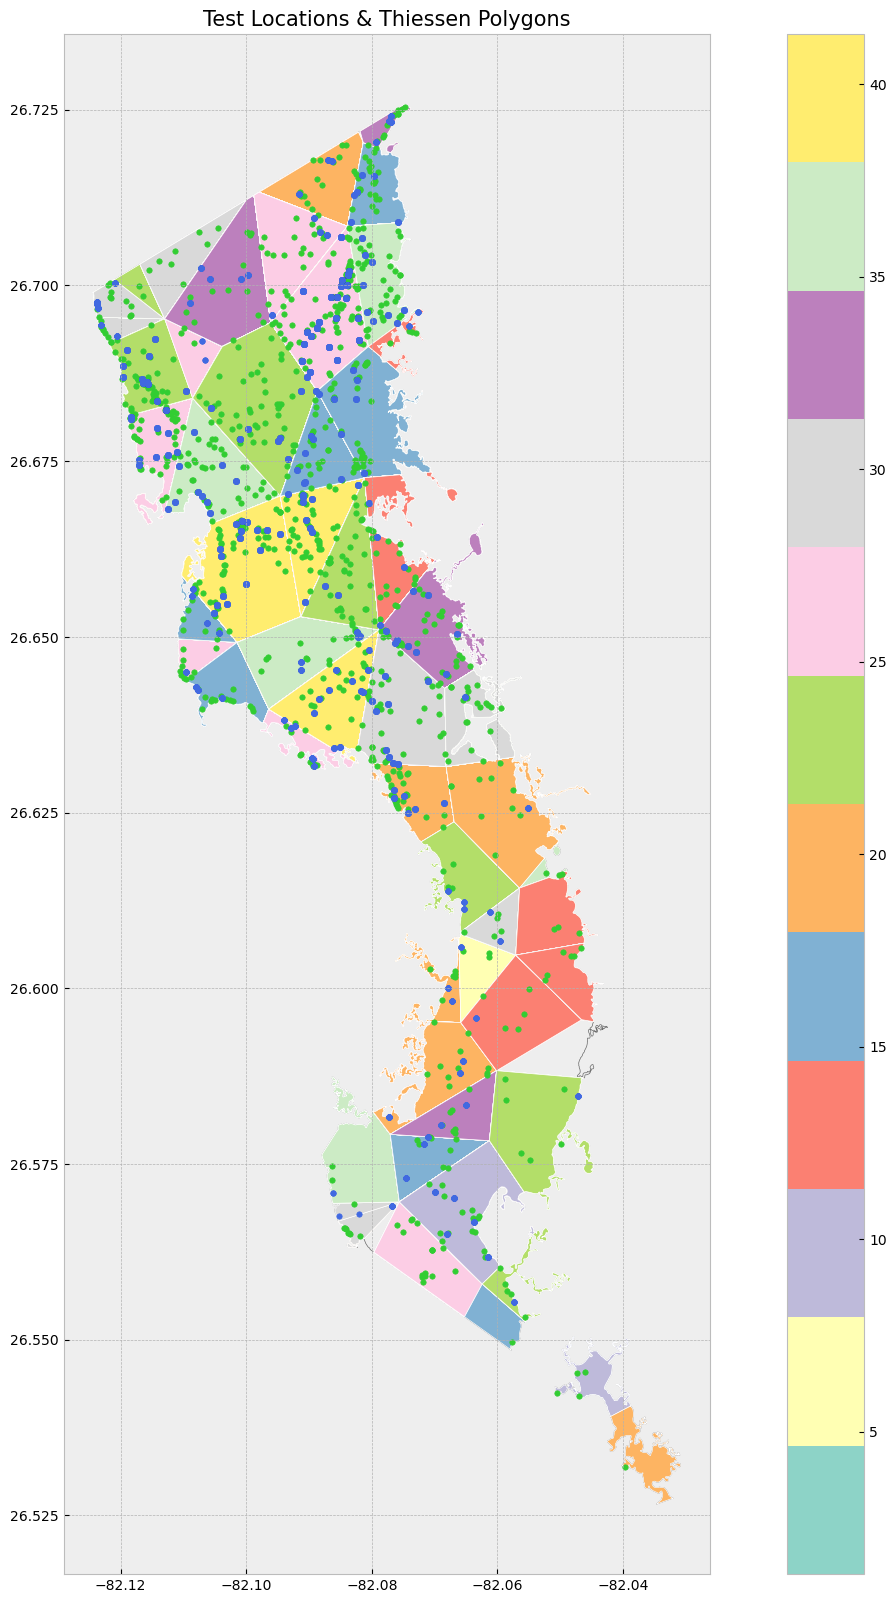

In [106]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 20))

# Stylize plots
plt.style.use('bmh')

# Plot data
basins_dissolved.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
tp_polys_clipped_values.plot(column = "VALUE_Thiessen", ax = ax, cmap = 'Set3', edgecolor = 'white', linewidth = 0.5,legend=True,label=True)
point_train_gdf.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 15)
point_test_pred_tp.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 15)

# Iterate through each rainfall train point to add a label with its value to the plot
# for index, row in point_train_gdf.iterrows():
#     plt.annotate(int(row.Actual_Value), (row.geometry.x, row.geometry.y))

# # Iterate through each rainfall test point to add a label with its value to the plot
# for index, row in point_test_pred_tp.iterrows():
#     plt.annotate(int(row.VALUE_Predict), (row.geometry.x, row.geometry.y))

# Set title
ax.set_title('Test Locations & Thiessen Polygons', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# Ordinary Kriging

In [177]:
# Create a 100 by 100 grid
# Horizontal and vertical cell counts should be the same
XX_pk_krig = np.linspace(min_x_point, max_x_point, 100)
YY_pk_krig = np.linspace(min_y_point, max_y_point, 100)

# Generate ordinary kriging object
OK = OrdinaryKriging(
    np.array(x_point),
    np.array(y_point),
    value_point,
    variogram_model = "linear",
    verbose = False,
    enable_plotting = False,
    coordinates_type = "euclidean",
)

# Evaluate the method on grid
Z_pk_krig, sigma_squared_p_krig = OK.execute("grid", XX_pk_krig, YY_pk_krig)

# Export raster
export_kde_raster(Z = Z_pk_krig, XX = XX_pk_krig, YY = YY_pk_krig,
                  min_x = min_x_point, max_x = max_x_point, min_y = min_y_point, max_y = max_y_point,
                  proj = proj, filename = "point_pk_kriging4.tif")

# Open raster
raster_pk = rasterio.open("point_pk_kriging4.tif")


# Create polygon with extent of raster
poly_shapely = box(*raster_pk.bounds)

# Create a dictionary with needed attributes and required geometry column
attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}

# Convert shapely object to a GeoDataFrame
raster_pk_extent = gpd.GeoDataFrame(attributes_df, geometry = 'geometry', crs = proj)

# Create copy of test dataset
point_test_gdf_pk_krig = point_test_gdf.copy()

# Subset the GeoDataFrame by checking which test points are within the raster extent polygon
# If a test point is beyond the extent of training points dataset, the kriging output may not cover that test point
point_test_gdf_pk_krig = point_test_gdf_pk_krig[point_test_gdf_pk_krig.within(raster_pk_extent.geometry.values[0])]

# Create list of XY coordinate pairs for the test points that fall within raster extent polygon
coords_point_test_pk_krig = [list(xy) for xy in zip(point_test_gdf_pk_krig["geometry"].x, point_test_gdf_pk_krig["geometry"].y)]

# Extract raster value at each test point and add the values to the GeoDataFrame
point_test_gdf_pk_krig["VALUE_Predict"] = [x[0] for x in raster_pk.sample(coords_point_test_pk_krig)]

# Generate out-of-sample R^2
out_r_squared_tp = r2_score(point_test_gdf_pk_krig.Actual_Value, point_test_gdf_pk_krig.VALUE_Predict)
print("PyKrige Kriging out-of-sample r-squared: {}".format(round(out_r_squared_tp, 2)))

# Display attribute table
print("\nAttribute Table: Random Points Interpolated Values - PyKrige Kriging Method")
display(point_test_gdf_pk_krig.head(2))


# Mask raster to counties shape
out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, extentShp.geometry.values, crop = True)

PyKrige Kriging out-of-sample r-squared: 0.05

Attribute Table: Random Points Interpolated Values - PyKrige Kriging Method


,geometry,Actual_Value,VALUE_Predict
0,POINT (-82.07728 26.63285),25.4,19.907309
1,POINT (-82.08625 26.57083),23.4,27.389732


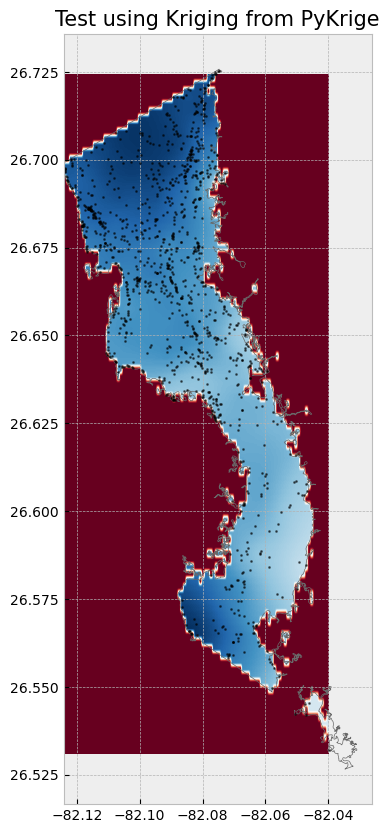

In [159]:
# Stylize plots
plt.style.use('bmh')

# Plot data
fig, ax = plt.subplots(1, figsize = (10, 10))
show(out_image_pk, ax = ax, transform = out_transform_pk, cmap = "RdBu")
ax.plot(x_point, y_point, 'k.', markersize = 2, alpha = 0.5)
extentShp.plot(ax = ax, color = 'none', edgecolor = 'dimgray',legend=True)
plt.gca().invert_yaxis()

# Set title
ax.set_title('Test using Kriging from PyKrige', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# Display plot
plt.show()

# Regression Kriging | EBK (Undone)

In [115]:
# import sys

# from sklearn.datasets import fetch_california_housing
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVR

# from pykrige.rk import RegressionKriging

# svr_model = SVR(C=0.1, gamma="auto")
# rf_model = RandomForestRegressor(n_estimators=100)
# lr_model = LinearRegression(normalize=True, copy_X=True, fit_intercept=False)

# models = [svr_model, rf_model, lr_model]

# try:
#     housing = fetch_california_housing()
# except PermissionError:
#     # this dataset can occasionally fail to download on Windows
#     sys.exit(0)

# # take the first 5000 as Kriging is memory intensive
# p = housing["data"][:5000, :-2]
# x = housing["data"][:5000, -2:]
# target = housing["target"][:5000]

# p_train, p_test, x_train, x_test, target_train, target_test = train_test_split(
#     p, x, target, test_size=0.3, random_state=42
# )

# for m in models:
#     print("=" * 40)
#     print("regression model:", m.__class__.__name__)
#     m_rk = RegressionKriging(regression_model=m, n_closest_points=10)
#     m_rk.fit(p_train, x_train, target_train)
#     print("Regression Score: ", m_rk.regression_model.score(p_test, target_test))
#     print("RK score: ", m_rk.score(p_test, x_test, target_test))

regression model: SVR
Finished learning regression model
Finished kriging residuals
Regression Score:  -0.034053855452918835
RK score:  0.6717847875615838
regression model: RandomForestRegressor
Finished learning regression model
Finished kriging residuals
Regression Score:  0.6998414958052108
RK score:  0.7376016211682401
regression model: LinearRegression
Finished learning regression model


C:\Users\xiang11\.conda\envs\geo\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Finished kriging residuals
Regression Score:  0.5277968398381672
RK score:  0.6125147997944014


# IDW

In [137]:
gdfTest = gpd.read_file("TestIDW/Myself/gdfTest.shp")
bd      = gpd.read_file("ManagedArea/ORCP_Managed_Areas_Oct2021.shp")
bd      = bd[bd["LONG_NAME"] == listArea[1]]
bd.to_file('TestIDW/Myself/bounds.shp', driver='ESRI Shapefile',crs="EPSG:4326")

In [132]:
gdfTest

,Latitude_D,Longitude_,ParameterN,ManagedAre,ResultValu,geometry
0,26.562700,-82.070400,Salinity,Matlacha Pass Aquatic Preserve,21.366850,POINT (-82.07040 26.56270)
1,26.628800,-82.067400,Salinity,Matlacha Pass Aquatic Preserve,19.999157,POINT (-82.06740 26.62880)
2,26.667800,-82.094600,Salinity,Matlacha Pass Aquatic Preserve,23.975257,POINT (-82.09460 26.66780)
3,26.531917,-82.039667,Salinity,Matlacha Pass Aquatic Preserve,20.900000,POINT (-82.03967 26.53192)
4,26.541967,-82.046967,Salinity,Matlacha Pass Aquatic Preserve,10.200000,POINT (-82.04697 26.54197)
...,...,...,...,...,...,...
1175,26.724366,-82.075883,Salinity,Matlacha Pass Aquatic Preserve,36.500000,POINT (-82.07588 26.72437)
1176,26.724417,-82.075800,Salinity,Matlacha Pass Aquatic Preserve,22.500000,POINT (-82.07580 26.72442)
1177,26.724950,-82.075883,Salinity,Matlacha Pass Aquatic Preserve,21.300000,POINT (-82.07588 26.72495)
1178,26.725133,-82.075233,Salinity,Matlacha Pass Aquatic Preserve,20.350000,POINT (-82.07523 26.72513)


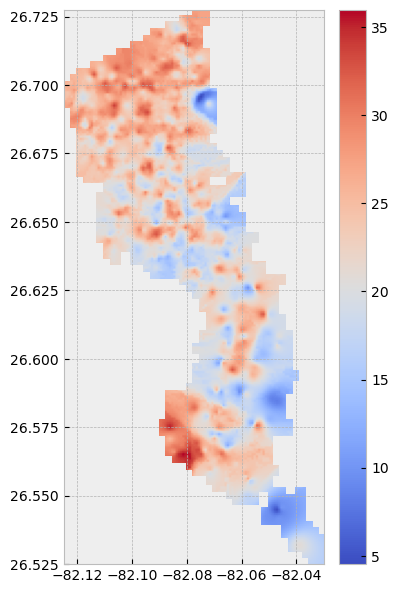

In [138]:
idw.idw_interpolation(
    input_point_shapefile="TestIDW/Myself/gdfTest.shp",
    extent_shapefile="TestIDW/Myself/bounds.shp",
    column_name="ResultValu",
    power=2,
    search_radious=10,
    output_resolution=250,
)

In [139]:
from pyidw import idw
from sklearn.metrics import mean_squared_error

original_value, interpolated_value = idw.accuracy_standard_idw(
    input_point_shapefile="TestIDW/Myself/gdfTest.shp",
    extent_shapefile="TestIDW/Myself/bounds.shp",
    column_name="ResultValu",
    power=2,
    search_radious=6,
    output_resolution=250,
)

print("RMSE:", mean_squared_error(original_value, interpolated_value, squared=False))

RMSE: 9.427057894979942
